In [2]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
#adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
#adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
#adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

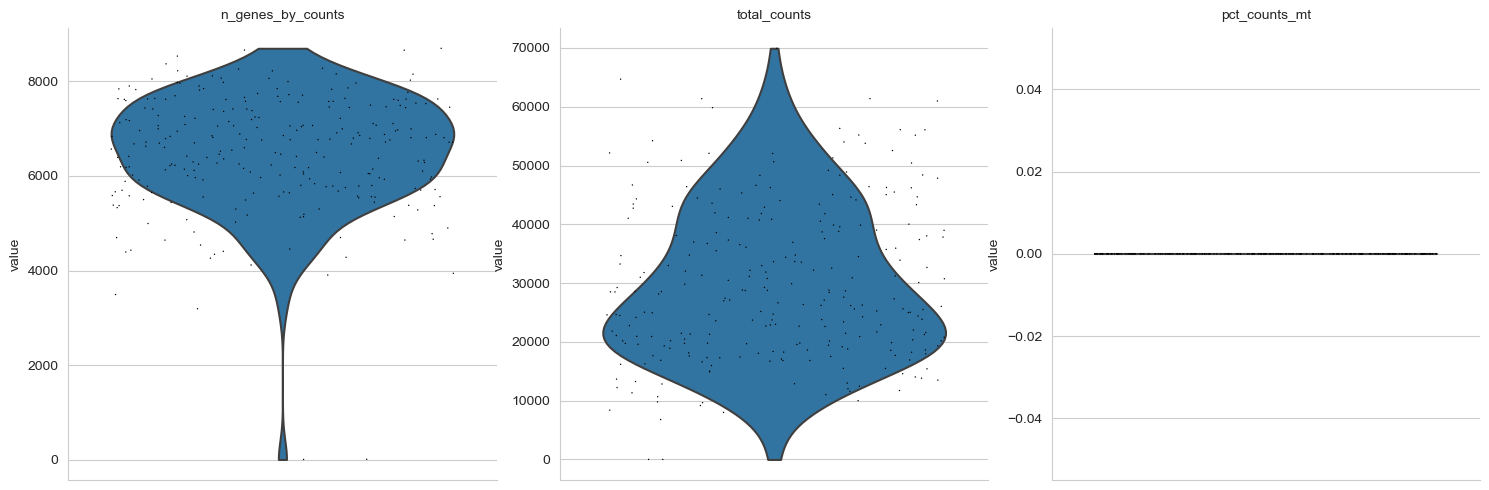

In [183]:
import numpy as np

from util import *
from Algorithm.graph import *
from Algorithm.distribution import *
from IO.read_10X import *

h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = read_10X_h5ad('F://Rep11_MOB_ST.h5ad', amplification=1000)
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]
sc.pl.violin(adata,
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [184]:
result = convolve(get_3d_matrix(adata), kernel=get_gaussian_kernel(size=3))
update_anndata(result, adata)

MemoryError: Unable to allocate 21.8 TiB for an array with shape (20159, 15031, 9868) and data type float64

In [190]:
adata.obs['x']

16.92x9.015       9032
16.945x11.075     9057
16.97x10.118      9082
16.939x12.132     9051
16.949x13.055     9061
                 ...  
23.124x24.046    15236
21.01x23.944     13122
22.053x23.962    14165
27.018x20.088    19130
17.964x10.137    10076
Name: x, Length: 262, dtype: int32

In [5]:
gene_list = list(adata.var.index)
len(gene_list)

9868

In [191]:
paper = ['Rab3b','Necab2','Tspan7','Cdr1','Slc17a7','4933405L10Rik','Taf7l','Gna14','Olfr635','Pmepa1','Pcp4','Apc','Rbfox3','Penk','Frzb','Fabp7','Slc6a11','Apod','S100a5','Arhgap33','Cplx1','Trnp1','Marcks','Atp1b1','Vtn','Trak2','Igf1','Gabra1','Igfbp2','Lpar1','Omp','Kif5b','Sorbs1','Cck','Nr2f2','Scd1','Cpe','Aqp4','Doc2g','Slc1a2','Nrgn','Cdhr1','Mcf2l','Kctd12','Unc13c','Foxd3','Prokr2','Gng13','Kcnh3','Camk2b','Baiap2','Ccnd1','Gpsm1','Pbx1','Sepp1','Apoe','Tubb2b','Ncdn','Glul','Sash1','Ptgds','Sparcl1','Mbp','Nrsn1','Igfbp5','Ptn','Sfrp5']
gene_list = adata.var[adata.var['gene_ids'].isin(paper)].index
len(gene_list)

62

In [192]:
gmm_dict = fit_gmms(adata, gene_list, n_comp=30, n_top_comp=30)

Processing ...: 100%|██████████| 62/62 [02:29<00:00,  2.42s/it]

Dropped genes number:1


In [85]:
# optimized_match  /  weight_match
arr = build_gmm_distance_array(gmm_dict, method='optimized_match')


Building distance array...: 100%|██████████| 61/61 [00:21<00:00,  2.88it/s]


In [226]:
from sklearn.cluster import SpectralClustering
def cluster(distance_array: pd.DataFrame,
            mds_components: int = 20,
            n_clusters: int = 10) -> np.array:
    """
    Given a distance matrix with the distances between each pair of objects in a set, and a chosen number of
    dimensions, N, an MDS algorithm places each object into N-dimensional space (a lower-dimensional representation)
    such that the between-object distances are preserved as well as possible.
    After that, run **K-Means** clustering and get the labels.

    Ref:
     - https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling
     - Multidimensional scaling. (2023, March 28). In Wikipedia. https://en.wikipedia.org/wiki/Multidimensional_scaling
    :param distance_array: Distance array dataframe
    :type distance_array: pd.DataFrame
    :param mds_components: Number of dimensions
    :type mds_components: int
    :param n_clusters: Number of clusters
    :type n_clusters: int
    :return: A list of labels for each element.
    :rtype: numpy.Array
    """
    index = distance_array.index
    # mds = MDS(n_components=mds_components, dissimilarity='precomputed')
    # embedding_position = mds.fit_transform(distance_array)
    a = 1/(distance_array+1)
    kmeans = SpectralClustering(n_clusters=n_clusters, affinity='precomputed').fit(a)
    result = pd.DataFrame(dict(gene_id=list(index), labels=list(kmeans.labels_)))
    return result

result = cluster(arr, n_clusters=8, mds_components=50)
result

,gene_id,labels
0,Pmepa1,2
1,Pcp4,1
2,Apc,1
3,Rbfox3,3
4,Gng13,0
...,...,...
56,Nrsn1,6
57,Igfbp5,7
58,Ptn,6
59,Unc13c,2


In [24]:
arr = build_mse_distance_array(adata, gene_list)
result = cluster(arr, n_clusters=6, mds_components=20)

Building distance array...: 100%|██████████| 62/62 [00:12<00:00,  5.01it/s]

Embedding...
Clustering...


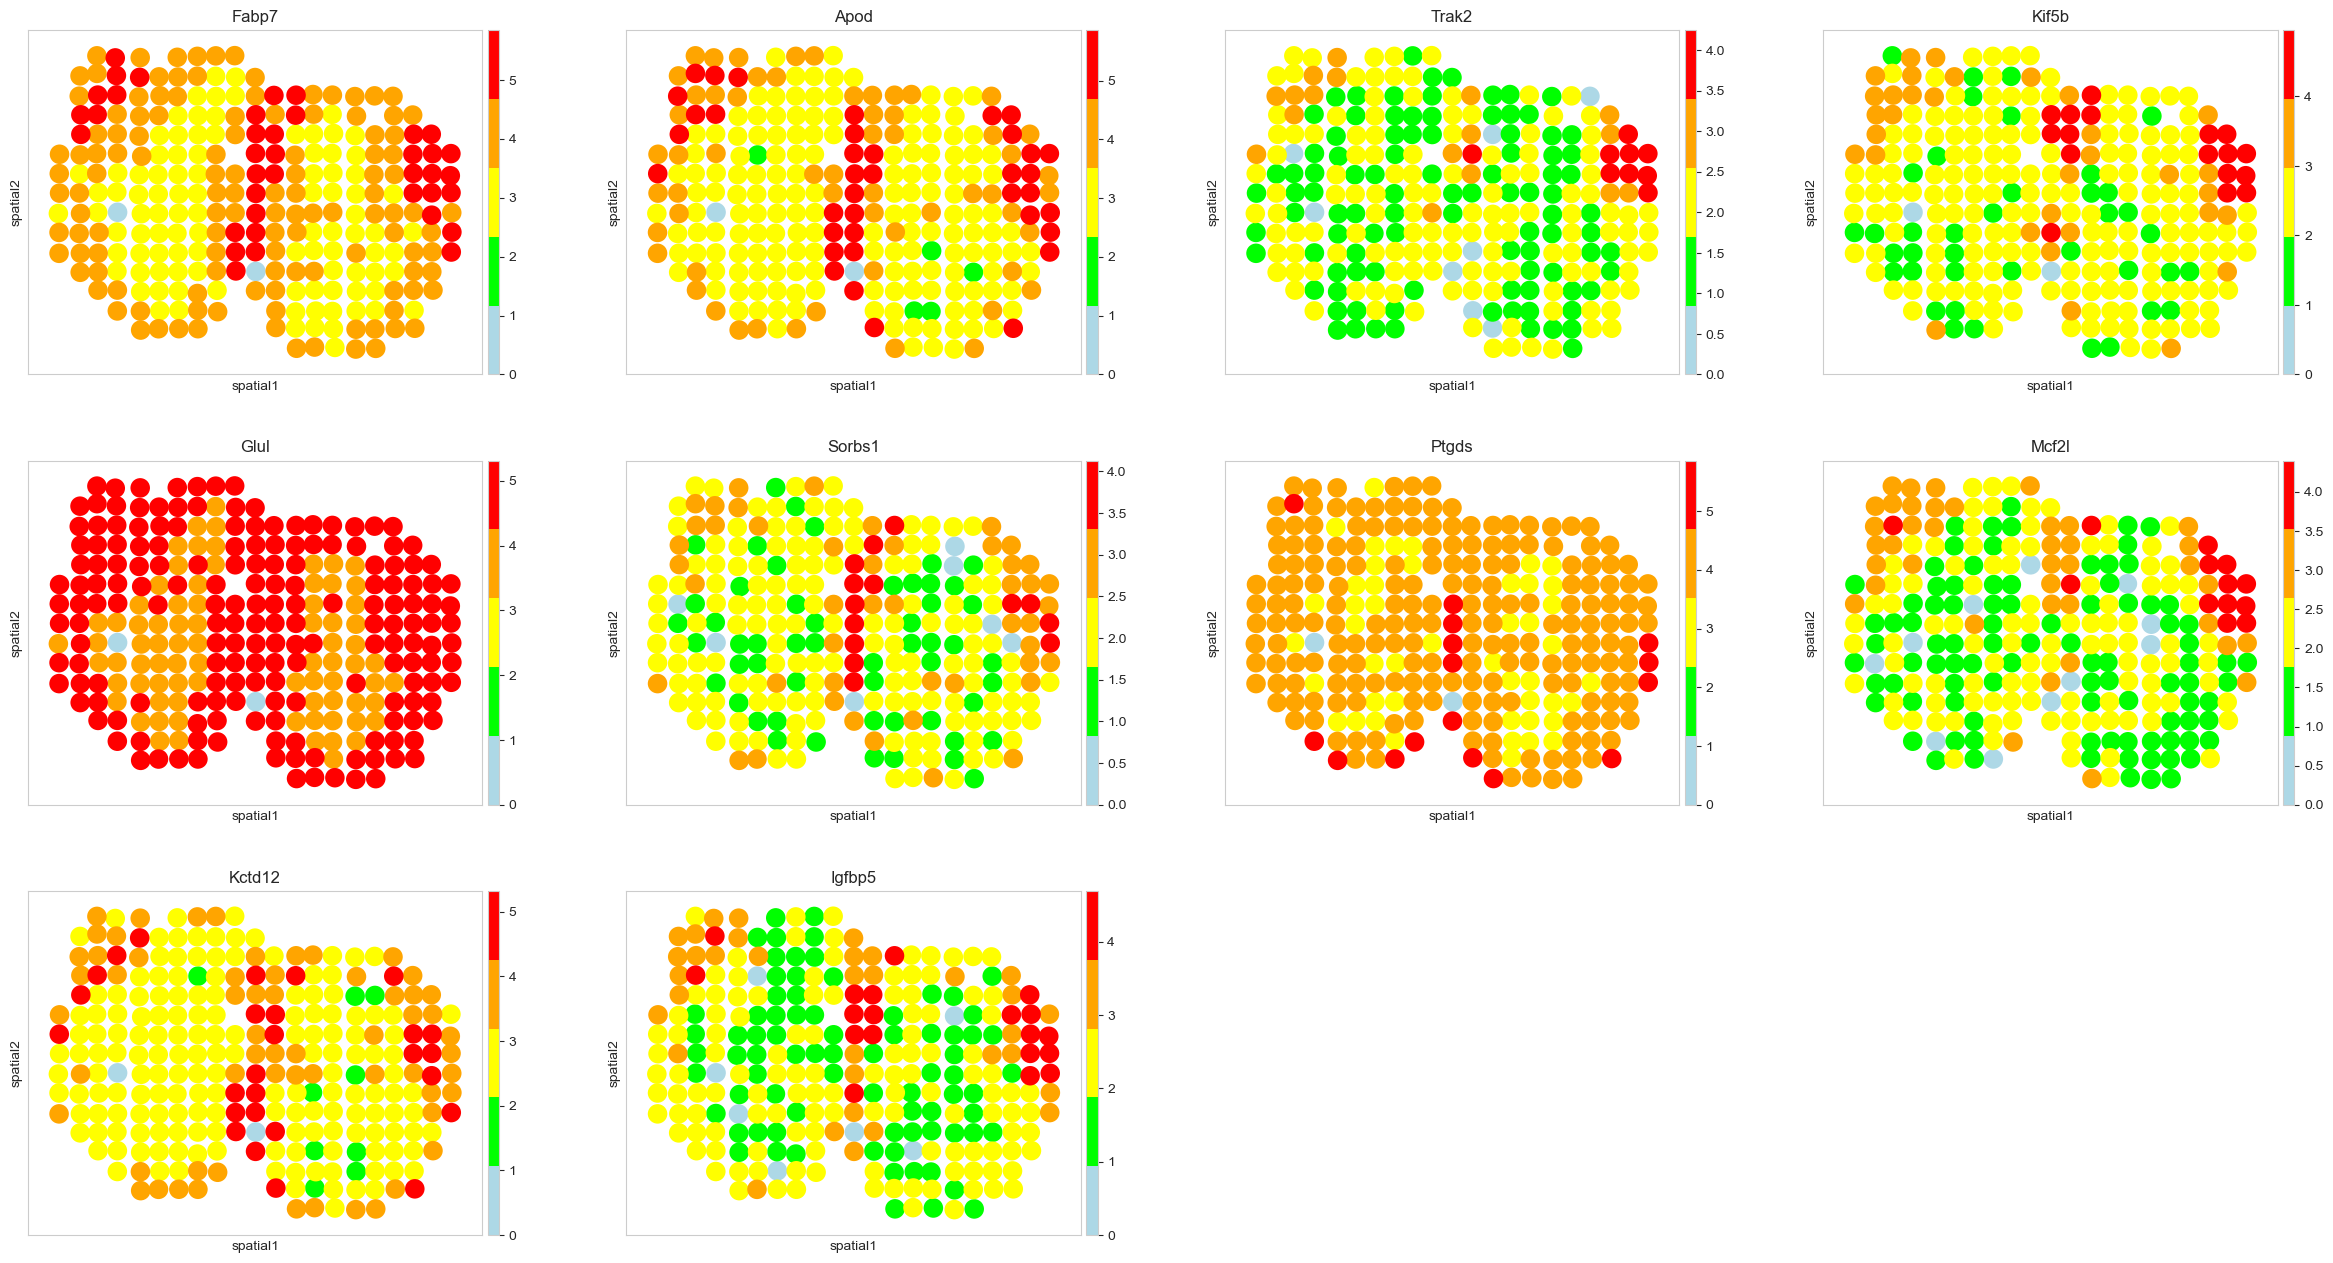

In [236]:
import scanpy as sc
import matplotlib.colors as colors

new_colors = ['lightblue',  '#00FF00','#FFFF00', '#FFA500', '#FF0000']
new_cmap = colors.ListedColormap(new_colors)
sc.pl.spatial(adata,
              size=2,
              spot_size=.5,
              cmap=new_cmap,
              color=list(result[result['labels'] == 7]['gene_id']))

In [6]:
view_gmm(gmm_dict['Nrgn'], scope=(0, max(adata.obs['y'].max(), adata.obs['x'].max())), bin_count=100)


AttributeError: 'GMM' object has no attribute 'precisions_cholesky_'

In [12]:
gmm = fit_gmm(adata, 'Mbp',n_comp=20, top_components=5)

KeyboardInterrupt: 

In [52]:
view_gmm(gmm_dict['Doc2g'], scope=(0, max(adata.obs['y'].max(), adata.obs['x'].max())), bin_count=100)

AttributeError: 'GMM' object has no attribute 'score_samples'

<AxesSubplot:xlabel='labels', ylabel='Count'>

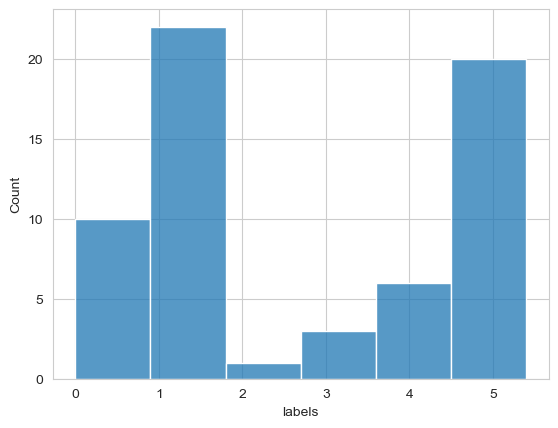

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(result['labels'], binwidth=.9)

In [10]:
gmm = fit_gmm(adata, 'Mbp', n_comp=20, top_components=5)

0.0